# Probabilistic Model Evaluation

When using deep learning models in production,
we do not have the luxury of having access to ground-truth.
However, it may be feasable to integrate a human domain expert
into production workflows.

In order to maximize throughput,
we must be selective about when we alert our human expert.
If we can understand the reliability of our model predictions
as a function of its self-reported confidence,
we can use this to guide business logic in our application.

## Setup Environment

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats.mstats import mquantiles
import tensorflow as tf
import tensorflow_probability as tfp

## Probabilistic Model

The chance of our model making a valid prediction
can be thought of as a
[Bernoulli](https://en.wikipedia.org/wiki/Bernoulli_distribution)
random variable:

$$\text{Valid Prediction}, V_i \sim \text{Ber}( p(c_i) ), i=1..N$$

where $p(c_i)$ is a
[logistic function](https://en.wikipedia.org/wiki/Logistic_function)
of the prediction confidence:

$$p(c) = \frac{1}{1+e^{\beta c + \alpha}}$$

We can use our ground-truth validations to evaluate
the likelihood that a given *logistic function*
with parameters $\alpha$ and $\beta$
"explains" the data.

This likelihood defines the following
joint log probability optimization function:

In [2]:
def validation_joint_log_prob(validation, confidence, alpha, beta):
    prior_alpha = tfp.distributions.Normal(loc=0., scale=1)
    prior_beta = tfp.distributions.Normal(loc=-5, scale=10)
    
    logistic_p = 1./(1. + tf.exp(beta * confidence + alpha))
    expected = tfp.distributions.Bernoulli(probs=logistic_p)
    
    return (
        prior_alpha.log_prob(alpha)
        + prior_beta.log_prob(beta)
        + tf.reduce_sum(expected.log_prob(validation))
    )

## Hamiltonian Monte Carlo

In [77]:
def hamiltonian_monte_carlo(
    validation,
    confidence,
    num_steps=1000,
    num_leapfrog_steps=4,
    step_size=0.01,
):
    # Initialize the HMC
    initial_chain_state = [
        0. * tf.ones([], dtype=tf.float32, name="init_alpha"),
        0. * tf.ones([], dtype=tf.float32, name="init_beta"),
    ]
    burnin = num_steps // 5
    
    # Rescale "beta" to be 10x magnitude of "alpha"
    unconstraining_bijectors = [
        tfp.bijectors.Identity(),
        tfp.bijectors.Scale(10),
    ]
    
    # Create a closure with our input data
    unnormalized_posterior_log_prob = (
        lambda *args: validation_joint_log_prob(
            validation,
            confidence,
            *args,
        )
    )
    
    # Define the HMC
    hmc = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.SimpleStepSizeAdaptation(
            inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=unnormalized_posterior_log_prob,
                num_leapfrog_steps=num_leapfrog_steps,
                step_size=step_size,
            ),
            num_adaptation_steps=int(burnin * 0.8)
        ),
        bijector=unconstraining_bijectors,
    )
    
    # Sample from the chain
    [
        posterior_alpha,
        posterior_beta,
    ], kernel_results = tfp.mcmc.sample_chain(
        num_results=num_steps,
        num_burnin_steps=burnin,
        current_state=initial_chain_state,
        kernel=hmc,
    )
    
    return posterior_alpha, posterior_beta, kernel_results

In [78]:
def hmc_stats(posterior_alpha, posterior_beta):
    posterior_alpha_1d = posterior_alpha[:,None]
    posterior_beta_1d = posterior_beta[:,None]
    
    mean_alpha = tf.reduce_mean(posterior_alpha_1d)
    mean_beta = tf.reduce_mean(posterior_beta_1d)
    
    def logistic(x, alpha, beta):
        return 1./(1. + tf.exp(beta * x + alpha))
    
    linspace = np.linspace(0, 1, 1000)[:,None]
    p_linspace = logistic(linspace.T, posterior_alpha_1d, posterior_beta_1d)
    mean_p = logistic(linspace.T, mean_alpha, mean_beta)
    
    quantiles = mquantiles(p_linspace, [0.025, 0.975], axis=0)
    
    return mean_alpha, mean_beta, linspace, p_linspace, mean_p, quantiles

## Example: Reasonable Data

In [79]:
reasonable_data = pd.read_csv("validations/reasonable.csv")
reasonable_data

,confidence,validation
0,0.111028,0
1,0.542757,1
2,0.178984,1
3,0.860905,1
4,0.696550,1
...,...,...
995,0.276820,1
996,0.175565,0
997,0.323033,1
998,0.715152,1


In [80]:
reasonable_validation = tf.convert_to_tensor(
    reasonable_data["validation"].to_numpy(),
    dtype=tf.float32,
)
reasonable_validation.shape

TensorShape([1000])

In [81]:
reasonable_confidence = tf.convert_to_tensor(
    reasonable_data["confidence"].to_numpy(),
    dtype=tf.float32,
)
reasonable_confidence.shape

TensorShape([1000])

In [82]:
%%time

reasonable_alpha, reasonable_beta, kernel_results = (
    hamiltonian_monte_carlo(
        reasonable_validation,
        reasonable_confidence,
    )
)

/home/mara/.local/share/virtualenvs/probabilistic-model-evaluation--jq05Z78/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


CPU times: user 39.7 s, sys: 0 ns, total: 39.7 s
Wall time: 39.7 s


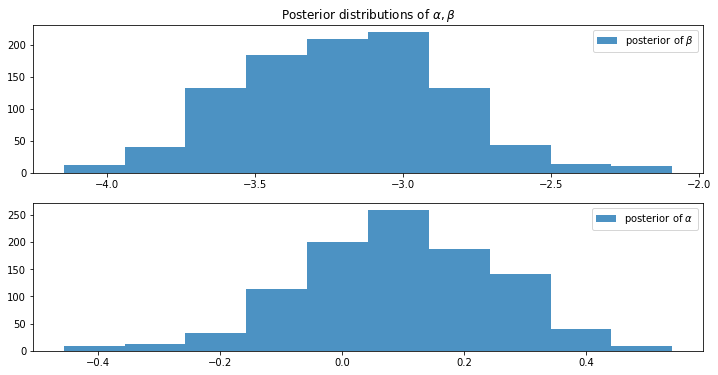

In [83]:
plt.figure(figsize=(12,6))

plt.subplot(211)
plt.title(r"Posterior distributions of $\alpha, \beta$")
plt.hist(reasonable_beta.numpy(), histtype='stepfilled', bins=10, alpha=0.8,
         label=r"posterior of $\beta$")
plt.legend()

plt.subplot(212)
plt.hist(reasonable_alpha.numpy(), histtype='stepfilled', bins=10, alpha=0.8,
         label=r"posterior of $\alpha$")
plt.legend();

In [87]:
(
    reasonable_alpha_mean,
    reasonable_beta_mean,
    reasonable_linspace,
    reasonable_p_linspace,
    reasonable_mean_p,
    reasonable_quantiles,
) = hmc_stats(reasonable_alpha, reasonable_beta)

Text(0.5, 1.0, 'Validation Probability given Prediction Confidence')

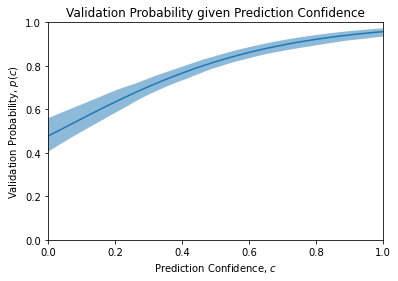

In [88]:
plt.fill_between(reasonable_linspace[:,0], *reasonable_quantiles, alpha=0.5)
plt.plot(reasonable_linspace, mean_p[0,:])
plt.xlim(reasonable_linspace.min(), reasonable_linspace.max())
plt.ylim(0,1)

plt.xlabel("Prediction Confidence, $c$")
plt.ylabel("Validation Probability, $p(c)$")
plt.title("Validation Probability given Prediction Confidence")

## Example: Random Data

In [89]:
random_data = pd.read_csv("validations/random.csv")
random_data

,confidence,validation
0,0.930547,0.0
1,0.101232,0.0
2,0.393576,1.0
3,0.515892,1.0
4,0.482551,0.0
...,...,...
995,0.343078,1.0
996,0.117733,1.0
997,0.862322,1.0
998,0.969050,0.0


In [90]:
random_validation = tf.convert_to_tensor(
    random_data["validation"].to_numpy(),
    dtype=tf.float32,
)
random_validation.shape

TensorShape([1000])

In [91]:
random_confidence = tf.convert_to_tensor(
    random_data["confidence"].to_numpy(),
    dtype=tf.float32,
)
random_confidence.shape

TensorShape([1000])

In [92]:
%%time

random_alpha, random_beta, kernel_results = (
    hamiltonian_monte_carlo(
        random_validation,
        random_confidence,
    )
)

/home/mara/.local/share/virtualenvs/probabilistic-model-evaluation--jq05Z78/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


CPU times: user 40.7 s, sys: 0 ns, total: 40.7 s
Wall time: 40.7 s


In [99]:
(
    random_alpha_mean,
    random_beta_mean,
    random_linspace,
    random_p_linspace,
    random_mean_p,
    random_quantiles,
) = hmc_stats(random_alpha, random_beta)

Text(0.5, 1.0, 'Validation Probability given Prediction Confidence')

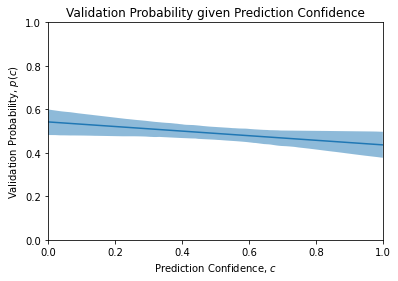

In [100]:
plt.fill_between(random_linspace[:,0], *random_quantiles, alpha=0.5)
plt.plot(random_linspace, random_mean_p[0,:])
plt.xlim(random_linspace.min(), random_linspace.max())
plt.ylim(0,1)

plt.xlabel("Prediction Confidence, $c$")
plt.ylabel("Validation Probability, $p(c)$")
plt.title("Validation Probability given Prediction Confidence")

## Example: Classification Model

In [101]:
finalmodel_data = pd.read_csv("validations/final_model.csv")
finalmodel_data

,confidence,validation
0,0.920206,0
1,0.997809,1
2,0.998636,1
3,0.995455,1
4,0.999386,1
...,...,...
187,0.999805,1
188,0.999201,1
189,0.987883,1
190,0.999173,1


In [102]:
finalmodel_validation = tf.convert_to_tensor(
    finalmodel_data["validation"].to_numpy(),
    dtype=tf.float32,
)
finalmodel_validation.shape

TensorShape([192])

In [103]:
finalmodel_confidence = tf.convert_to_tensor(
    finalmodel_data["confidence"].to_numpy(),
    dtype=tf.float32,
)
finalmodel_confidence.shape

TensorShape([192])

In [104]:
%%time

finalmodel_alpha, finalmodel_beta, kernel_results = (
    hamiltonian_monte_carlo(
        finalmodel_validation,
        finalmodel_confidence,
    )
)

/home/mara/.local/share/virtualenvs/probabilistic-model-evaluation--jq05Z78/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


CPU times: user 41.9 s, sys: 9.82 ms, total: 41.9 s
Wall time: 41.9 s


In [105]:
(
    finalmodel_alpha_mean,
    finalmodel_beta_mean,
    finalmodel_linspace,
    finalmodel_p_linspace,
    finalmodel_mean_p,
    finalmodel_quantiles,
) = hmc_stats(finalmodel_alpha, finalmodel_beta)

Text(0.5, 1.0, 'Validation Probability given Prediction Confidence')

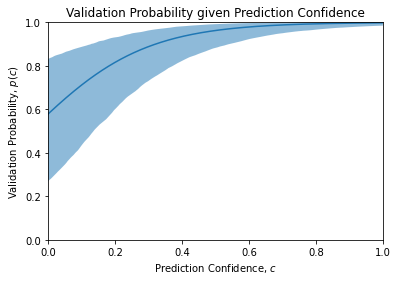

In [106]:
plt.fill_between(finalmodel_linspace[:,0], *finalmodel_quantiles, alpha=0.5)
plt.plot(finalmodel_linspace, finalmodel_mean_p[0,:])
plt.xlim(finalmodel_linspace.min(), finalmodel_linspace.max())
plt.ylim(0,1)

plt.xlabel("Prediction Confidence, $c$")
plt.ylabel("Validation Probability, $p(c)$")
plt.title("Validation Probability given Prediction Confidence")

## Example: Partially Trained Model

In [101]:
partialmodel_data = pd.read_csv("validations/partial_model.csv")
partialmodel_data

,confidence,validation
0,0.920206,0
1,0.997809,1
2,0.998636,1
3,0.995455,1
4,0.999386,1
...,...,...
187,0.999805,1
188,0.999201,1
189,0.987883,1
190,0.999173,1


In [102]:
partialmodel_validation = tf.convert_to_tensor(
    partialmodel_data["validation"].to_numpy(),
    dtype=tf.float32,
)
partialmodel_validation.shape

TensorShape([192])

In [103]:
partialmodel_confidence = tf.convert_to_tensor(
    partialmodel_data["confidence"].to_numpy(),
    dtype=tf.float32,
)
partialmodel_confidence.shape

TensorShape([192])

In [104]:
%%time

partialmodel_alpha, finalmodel_beta, kernel_results = (
    hamiltonian_monte_carlo(
        partialmodel_validation,
        partialmodel_confidence,
    )
)

/home/mara/.local/share/virtualenvs/probabilistic-model-evaluation--jq05Z78/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


CPU times: user 41.9 s, sys: 9.82 ms, total: 41.9 s
Wall time: 41.9 s


In [105]:
(
    finalmodel_alpha_mean,
    finalmodel_beta_mean,
    finalmodel_linspace,
    finalmodel_p_linspace,
    finalmodel_mean_p,
    finalmodel_quantiles,
) = hmc_stats(finalmodel_alpha, finalmodel_beta)

Text(0.5, 1.0, 'Validation Probability given Prediction Confidence')

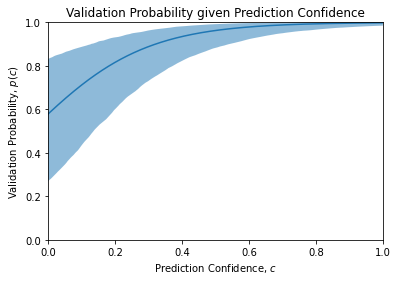

In [106]:
plt.fill_between(finalmodel_linspace[:,0], *finalmodel_quantiles, alpha=0.5)
plt.plot(finalmodel_linspace, finalmodel_mean_p[0,:])
plt.xlim(finalmodel_linspace.min(), finalmodel_linspace.max())
plt.ylim(0,1)

plt.xlabel("Prediction Confidence, $c$")
plt.ylabel("Validation Probability, $p(c)$")
plt.title("Validation Probability given Prediction Confidence")

## References

* https://colab.research.google.com/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_TFP.ipynb
* https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/HamiltonianMonteCarlo